# **Notebook 1: Data Loading, Preprocessing, Data Augmentation, Descriptives**

## Steps
1) Loading required packages for the project

2) Preprocessing
- De-duplicating features
- Adding RUL, implementing piece-wise linearity
- Data standardization

3) Plotting diagnostics and descriptives
- Dropping constant features


4) Data augmentation

5) Creating and saving the final datasets


## Loading Packages and Data

This block loads all necessary packages to perform pre-processing. Subsequently, it loads the C-MAPSS data. The original data consists of 4 training files, four test files and four RUL files which contain the true RULs corresponding to the test files.

In [3]:
#----------------------------
# 1) Load packages
#----------------------------
import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from google.colab import drive

In [4]:
#----------------------------
# 2) Load data
#----------------------------

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/I Learn Deep/'
file_path_data = f'{file_path}/data/'

# Create subfolders if they do not already exist
os.makedirs(f'{file_path}tensors/transformer/', exist_ok=True)

ids = ['FD001', 'FD002', 'FD003', 'FD004']
data = {}

# Load and assign column names
for id_ in ids:
    for split in ['train', 'test']:
        path = f'{file_path_data}{split}_{id_}.txt'
        raw = np.loadtxt(path)

        # Column names
        n_cols = raw.shape[1]
        col_names = ['engine', 'time']
        col_names += [f'oc_{i+1}' for i in range(3)]
        col_names += [f's_{i+1}' for i in range(n_cols - 5)]

        # Store as DataFrame with column names
        data[f'{id_}_{split}'] = pd.DataFrame(raw, columns=col_names)

    # RUL (for test set)
    data[f'{id_}_rul'] = np.loadtxt(f'{file_path_data}RUL_{id_}.txt')

Mounted at /content/drive


# Descriptives

This block produces a simple table containing information about the four datasets, namely their name, their shapes, the number of different engines contained, the maximum length of any engine's time series, the number of operating conditions and the number of fault modes. This information is reproduced in the data section of the report.

In [5]:
#----------------------------
# 3) Table with key characteristics
#----------------------------
rows = []
for id_ in ids:
    train = data[f'{id_}_train']
    test = data[f'{id_}_test']
    rul = data[f'{id_}_rul']

    engines = train['engine'].nunique()
    max_time = int(train['time'].max())

    # Define based on dataset
    if id_ in ['FD001', 'FD003']:
        num_conditions = 1
    else:
        num_conditions = 6

    if id_ in ['FD001', 'FD002']:
        num_faults = 1
    else:
        num_faults = 2

    rows.append([
        id_,
        train.shape,
        test.shape,
        engines,
        max_time,
        num_conditions,
        num_faults
    ])

df = pd.DataFrame(rows, columns=[
    'Dataset', 'Train Shape', 'Test Shape',
    'Engines', 'Maximum Time',
    'Operating Conditions', 'Fault Modes'
])

print(df)


  Dataset  Train Shape   Test Shape  Engines  Maximum Time  \
0   FD001  (20631, 26)  (13096, 26)      100           362   
1   FD002  (53759, 26)  (33991, 26)      260           378   
2   FD003  (24720, 26)  (16596, 26)      100           525   
3   FD004  (61249, 26)  (41214, 26)      249           543   

   Operating Conditions  Fault Modes  
0                     1            1  
1                     6            1  
2                     1            2  
3                     6            2  


# Preprocessing

This section contains the full pre-processing schedule for the C-MAPSS data.

## Removing highly correlated features and creating piecewise RUL

We begin by removing several features that are perfectly correlated with other features or operating conditions. This serves to de-duplicate the information contained in the feature matrix. We proceed recursively and report any dropped features.

Furthermore, we set the parameter for the construction of the piece-wise linear RUL function, *pw_linear_point*. This parameter controls up to which point the RUL is modeled as a constant horizontal line before decreasing linearly. Based on the existing literature, we set this hinge point to 120.

We then produce the training and test sets. For the training set, the true RUL parameter is not contained in the data. Instead, each engine runs to failure, meaning the each engine's final period is the point in time when its RUL decreased to 0. We use this to calculate RUL as *max_time - current_time*. For the test set, the true RUL is contained in a separate file and is added to the test data in a similar fashion by counting down from the final RUL.

In both cases, we cap the RUL at *pw_linear_point* = 120 to create the piece-wise linear RUL variable.

In [6]:
#----------------------------
# 4) Preprocessing
#----------------------------

# Parameters
pw_linear_point = 120

def remove_duplicate_features(data_dict, id_, correlation_threshold=0.999):

    print(f"\nRemoving duplicate features for {id_} (correlation > {correlation_threshold})")

    df = data_dict[f'{id_}_train']

    # Identify sensor columns, excluding metadata (i.e. engine number, time) and OCs
    cols_to_exclude = ['engine', 'time', 'RUL', 'RUL_pw', 'cluster', 'oc_1', 'oc_2', 'oc_3']
    feature_cols = df.columns.difference(cols_to_exclude, sort=False).tolist()

    # Calculate correlation matrix for all features
    corr_matrix = df[feature_cols].corr().abs()

    # Create set to track features to remove
    features_to_remove = set()

    # Now we recursively remove highly correlated features
    change_made = True
    while change_made:
        change_made = False

        # Get updated list of features to check (excluding those that are already marked for removal)
        current_features = [f for f in feature_cols if f not in features_to_remove]

        # Check all pairs of remaining features
        for i, feat_i in enumerate(current_features):
            if change_made:
                break

            for j in range(i+1, len(current_features)):
                feat_j = current_features[j]

                # Again get correlation from matrix
                corr = corr_matrix.loc[feat_i, feat_j]

                # If correlation exceeds threshold, remove one feature
                if corr > correlation_threshold:
                    # Remove the second feature
                    print(f"High correlation ({corr:.6f}) between {feat_i} and {feat_j}")
                    print(f"Removing {feat_j}")

                    features_to_remove.add(feat_j)
                    change_made = True
                    break

    # Apply removals to both train and test sets
    # It is important to remove the same features in the test set as well so both
    # X datasets have the same structure

    if features_to_remove:
        print(f"\nRemoving {len(features_to_remove)} duplicate features:")
        print(f"Features to remove: {features_to_remove}")

        # Remove from train set
        train_df = data_dict[f'{id_}_train'].drop(columns=features_to_remove)
        print(f"Original train shape: {data_dict[f'{id_}_train'].shape}")
        print(f"New train shape: {train_df.shape}")

        # Remove from test set
        test_df = data_dict[f'{id_}_test'].drop(columns=features_to_remove)
        print(f"Original test shape: {data_dict[f'{id_}_test'].shape}")
        print(f"New test shape: {test_df.shape}")

        # Update data dictionary
        data_dict[f'{id_}_train'] = train_df
        data_dict[f'{id_}_test'] = test_df
    else:
        print("No duplicate features found (correlation > 0.999)")

    return data_dict

for id_ in ids:
    data = remove_duplicate_features(data, id_)

# -----------------------------
# Building training set
# Creating piece-wise RUL
# -----------------------------

for id_ in ids:
    df = data[f'{id_}_train']
    rul = []
    for eid in df['engine'].unique():
        engine_df = df[df['engine'] == eid]
        rul.extend(engine_df['time'].max() - engine_df['time'])
    df['RUL']    = rul
    df['RUL_pw'] = df['RUL'].clip(upper=pw_linear_point)
    df.drop(columns=['RUL'], inplace=True)
    data[f'{id_}_train'] = df

# -----------------------------
# Building test set
# Creating piece-wise RUL
# -----------------------------
for id_ in ids:
    test_df   = data[f'{id_}_test']
    final_rul = data[f'{id_}_rul']
    full_rul  = []
    for i, eid in enumerate(test_df['engine'].unique()):
        engine_df = test_df[test_df['engine'] == eid]
        L = len(engine_df)
        full_rul.extend(range(L + int(final_rul[i]) - 1, int(final_rul[i]) - 1, -1))
    test_df['RUL']    = full_rul
    test_df['RUL_pw'] = test_df['RUL'].clip(upper=pw_linear_point)
    test_df.drop(columns=['RUL'], inplace=True)
    data[f'{id_}_test'] = test_df


Removing duplicate features for FD001 (correlation > 0.999)
No duplicate features found (correlation > 0.999)

Removing duplicate features for FD002 (correlation > 0.999)
High correlation (0.999993) between s_7 and s_12
Removing s_12
High correlation (0.999146) between s_7 and s_20
Removing s_20
High correlation (0.999145) between s_7 and s_21
Removing s_21
High correlation (0.999999) between s_8 and s_18
Removing s_18
High correlation (0.999998) between s_13 and s_19
Removing s_19

Removing 5 duplicate features:
Features to remove: {'s_20', 's_21', 's_12', 's_18', 's_19'}
Original train shape: (53759, 26)
New train shape: (53759, 21)
Original test shape: (33991, 26)
New test shape: (33991, 21)

Removing duplicate features for FD003 (correlation > 0.999)
No duplicate features found (correlation > 0.999)

Removing duplicate features for FD004 (correlation > 0.999)
High correlation (0.999993) between s_7 and s_12
Removing s_12
High correlation (0.999142) between s_7 and s_20
Removing s_

## Data Normalization

We now proceed to standardize the data as the sensors have very different ranges. As usual, we standardize by subtracting the mean and dividing by the standard deviation. However, FD001 / FD003 differ from FD002 / FD004 in that the former have 1 and the latter have 6 sets of operating conditions. Since different operating conditions mean starkly similar contexts for the sensor measurements (e.g. on the ground vs in the air, etc.), we follow the relevant literature, particularly Chadha et al. (2021), by identifying the sets of operating conditions via clustering and subsequently standardizing within each cluster.

The clustering is necessary because the operating conditions, while normally constant, are distorted by noise introduced during the simulation process. This means that the set of true operating conditions (24, 100, 60) might show up in the data as (23.59, 101.02, 60.17) instead.

Visual analysis in steps 6 and 7 (see report for details) validates our approach.

In [7]:
# ----------------------------
# 5) Data Normalization
# ----------------------------

# We define three modes of normalization, namely over the entire dataset,
# over clusters based on the operating conditions, and over each engine
# separately. We wrap this in a function so it can be reused for the visualization
# below.

def normalize_cmapss_one_id(data, id_, normalized_data, scalers, normalization_modes):
    mode = normalization_modes[id_]
    print(f"Normalizing {id_} using mode: {mode}")

    train_df = data[f'{id_}_train']
    test_df = data[f'{id_}_test']
    train_cols = train_df.columns.tolist()
    feature_cols = [i for i, col in enumerate(train_cols) if col not in ['engine', 'time', 'RUL', 'RUL_pw', 'cluster']]

    train_array = train_df.values
    test_array = test_df.values

    if mode == 'none':
        normalized_data[f'{id_}_train_rul_norm'] = train_df.copy()
        normalized_data[f'{id_}_test_rul_norm'] = test_df.copy()

    elif mode == 'global':
        scaler = StandardScaler()
        train_array[:, feature_cols] = scaler.fit_transform(train_array[:, feature_cols])
        test_array[:, feature_cols] = scaler.transform(test_array[:, feature_cols])

        normalized_data[f'{id_}_train_rul_norm'] = pd.DataFrame(train_array, columns=train_cols)
        normalized_data[f'{id_}_test_rul_norm'] = pd.DataFrame(test_array, columns=train_cols)
        scalers[id_] = scaler

    elif mode == 'engine':
        for eid in np.unique(train_array[:, 0]):
            idx = train_array[:, 0] == eid
            scaler = StandardScaler()
            train_array[np.ix_(idx, feature_cols)] = scaler.fit_transform(train_array[np.ix_(idx, feature_cols)])

        for eid in np.unique(test_array[:, 0]):
            idx = test_array[:, 0] == eid
            scaler = StandardScaler()
            test_array[np.ix_(idx, feature_cols)] = scaler.fit_transform(test_array[np.ix_(idx, feature_cols)])

        normalized_data[f'{id_}_train_rul_norm'] = pd.DataFrame(train_array, columns=train_cols)
        normalized_data[f'{id_}_test_rul_norm'] = pd.DataFrame(test_array, columns=train_cols)

    elif mode == 'cluster':
        settings = train_array[:, 2:5]
        kmeans = KMeans(n_clusters=6, random_state=42)
        train_labels = kmeans.fit_predict(settings)
        train_array = np.column_stack((train_array, train_labels))

        # Normalize per cluster
        cluster_rows = []
        for oc in range(6):
            idx = train_array[:, -1] == oc
            sub = train_array[idx]
            scaler = StandardScaler()
            sub[:, feature_cols] = scaler.fit_transform(sub[:, feature_cols])
            cluster_rows.append(sub)
        train_array = np.vstack(cluster_rows)

        # Test data: assign clusters from train kmeans, normalize per cluster
        test_settings = test_array[:, 2:5]
        test_labels = kmeans.predict(test_settings)
        test_array = np.column_stack((test_array, test_labels))

        cluster_rows_test = []
        for oc in range(6):
            idx = test_array[:, -1] == oc
            sub = test_array[idx]
            if len(sub) > 0:
                scaler = StandardScaler()
                sub[:, feature_cols] = scaler.fit_transform(sub[:, feature_cols])
            cluster_rows_test.append(sub)
        test_array = np.vstack(cluster_rows_test)

        train_cols += ['cluster']
        normalized_data[f'{id_}_train_rul_norm'] = pd.DataFrame(train_array, columns=train_cols)
        normalized_data[f'{id_}_test_rul_norm'] = pd.DataFrame(test_array, columns=train_cols)

# Now normalize the data
normalized_data = {}
scalers = {}
ids = ['FD001', 'FD002', 'FD003', 'FD004']

# This controls which method we use for which dataset
# We ultimately decided not to use per-engine-normalization but kept it as an
# option within the function.

normalization_modes = {
    'FD001': 'global',
    'FD002': 'cluster',
    'FD003': 'global',
    'FD004': 'cluster'
}

for id_ in ids:
    normalize_cmapss_one_id(data, id_, normalized_data, scalers, normalization_modes)

Normalizing FD001 using mode: global
Normalizing FD002 using mode: cluster
Normalizing FD003 using mode: global
Normalizing FD004 using mode: cluster


Normalizing FD002 using mode: global
Normalizing FD002 using mode: cluster


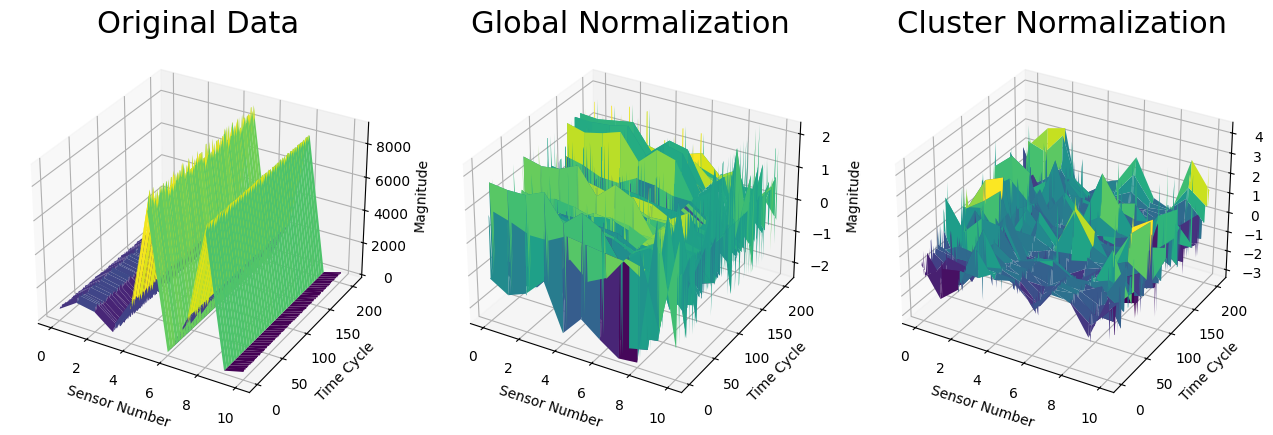

In [8]:
# ----------------------------
# 6) Visualization of Data Normalization
# ----------------------------

def plot_normalizations(data, id_, engine_id=1):

    # Get raw data
    raw_train = data[f'{id_}_train']

    # Sensors to use
    all_columns = raw_train.columns.tolist()
    sensor_columns = [col for col in all_columns if col.startswith('s_')]
    excluded_sensors = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
    selected_sensors = [col for col in sensor_columns if col not in excluded_sensors]

    raw_engine = raw_train[raw_train['engine'] == engine_id][selected_sensors]

    # Global normalization
    normalized_data_global = {}
    scalers_global = {}
    normalization_modes_global = {'FD001': 'global', 'FD002': 'global', 'FD003': 'global', 'FD004': 'cluster'}
    normalize_cmapss_one_id(data, id_, normalized_data_global, scalers_global, normalization_modes_global)

    global_engine = normalized_data_global[f'{id_}_train_rul_norm']
    global_engine = global_engine[global_engine['engine'] == engine_id][selected_sensors]

    # Cluster normalization
    normalized_data_cluster = {}
    scalers_cluster = {}
    normalization_modes_cluster = {'FD001': 'global', 'FD002': 'cluster', 'FD003': 'global', 'FD004': 'cluster'}
    normalize_cmapss_one_id(data, id_, normalized_data_cluster, scalers_cluster, normalization_modes_cluster)

    cluster_engine = normalized_data_cluster[f'{id_}_train_rul_norm']
    cluster_engine = cluster_engine[cluster_engine['engine'] == engine_id][selected_sensors]

    # Prepare grid (we swap sensor and time axis to make the structure better visible)
    time_cycles = np.arange(raw_engine.shape[0])
    sensor_numbers = np.arange(len(selected_sensors))
    sensor_grid, time_grid = np.meshgrid(sensor_numbers, time_cycles)

    # Plotting
    fig = plt.figure(figsize=(16, 6))
    # Original
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    surf1 = ax1.plot_surface(sensor_grid, time_grid, raw_engine.values, cmap='viridis')
    ax1.set_xlabel('Sensor Number')
    ax1.set_ylabel('Time Cycle')
    ax1.set_zlabel('Magnitude')
    ax1.set_title('Original Data', fontsize=22)

    # With global normalization
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    surf2 = ax2.plot_surface(sensor_grid, time_grid, global_engine.values, cmap='viridis')
    ax2.set_xlabel('Sensor Number')
    ax2.set_ylabel('Time Cycle')
    ax2.set_zlabel('Magnitude')
    ax2.set_title('Global Normalization', fontsize=22)

    # With cluster normalization for comparison
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    surf3 = ax3.plot_surface(sensor_grid, time_grid, cluster_engine.values, cmap='viridis')
    ax3.set_xlabel('Sensor Number')
    ax3.set_ylabel('Time Cycle')
    ax3.set_zlabel('Magnitude')
    ax3.set_title('Cluster Normalization', fontsize=22)

    plt.subplots_adjust(wspace=0.15)
    plt.savefig(f'{id_}_normalizations.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_normalizations(data, id_='FD002', engine_id=3)

## Plotting of distributions and engine plots

We now additionally plot distributions of all features in each dataset as well as 20 randomly chosen engines for each sensor in each dataset. This serves two purposes: it helps us understand the structure of the data better as well as validating our pre-processing steps that we have already undertaken.

The first function simply plots histograms of each feature in each dataset. The second function chooses 20 random engines and plots their feature values against time / RUL.

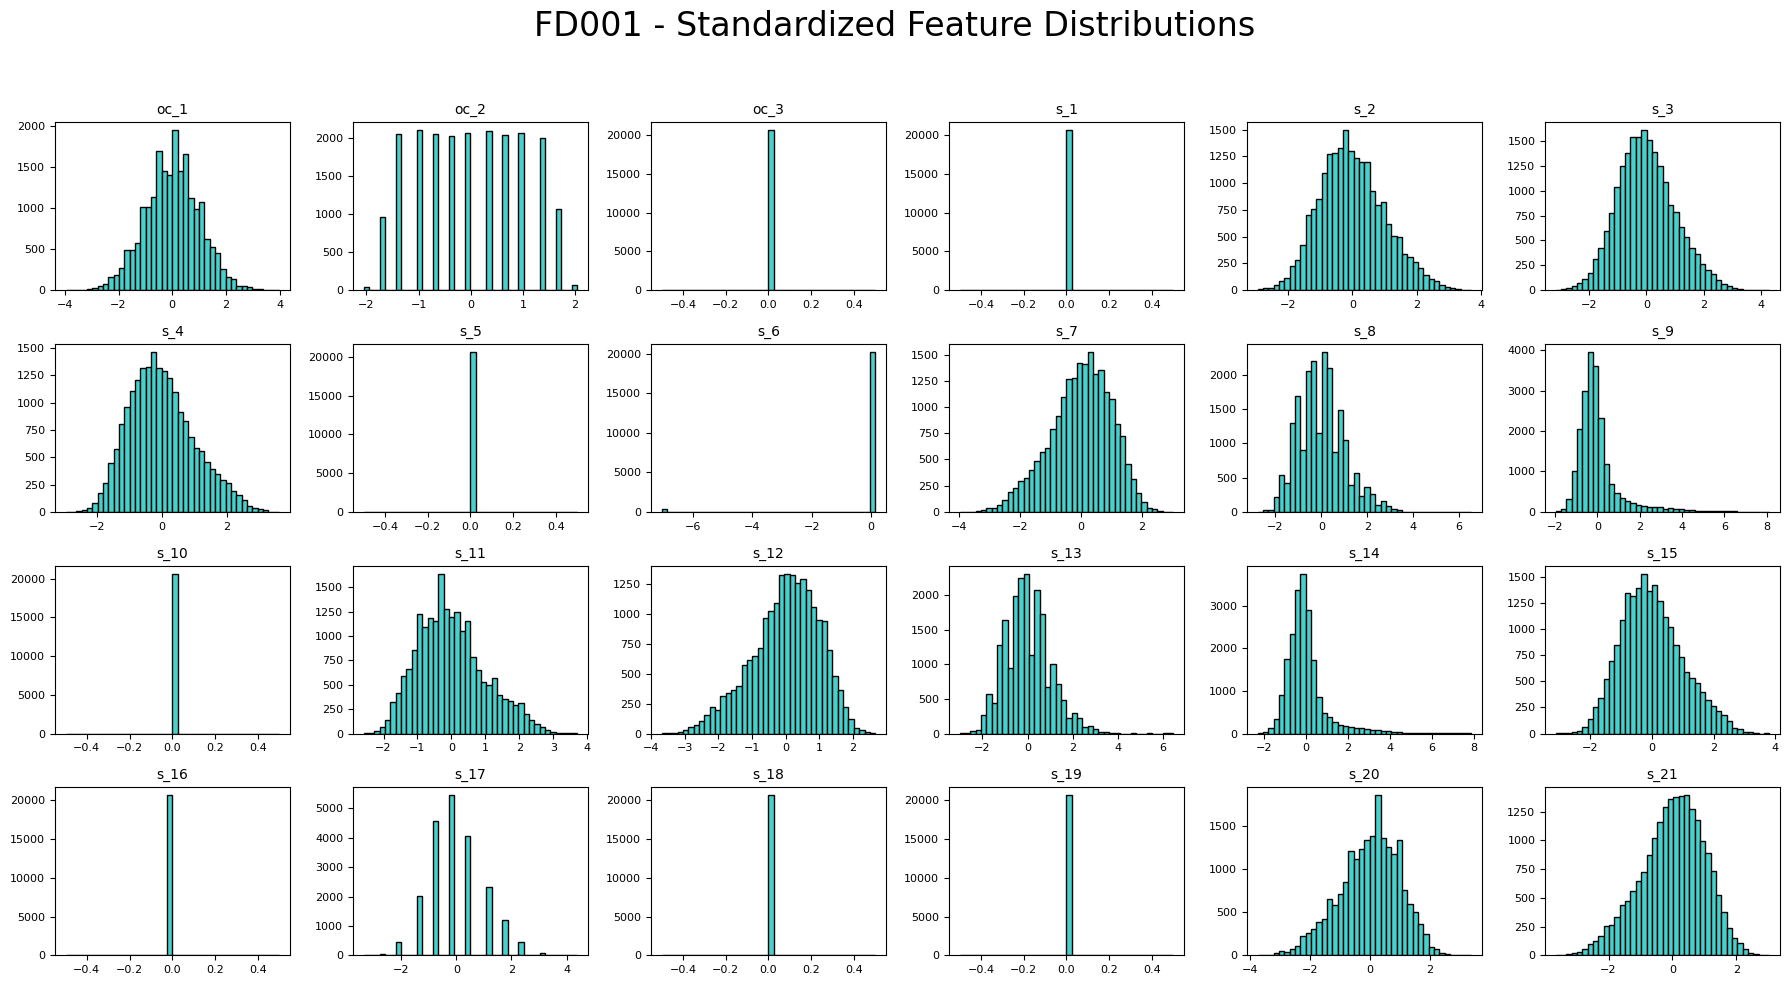

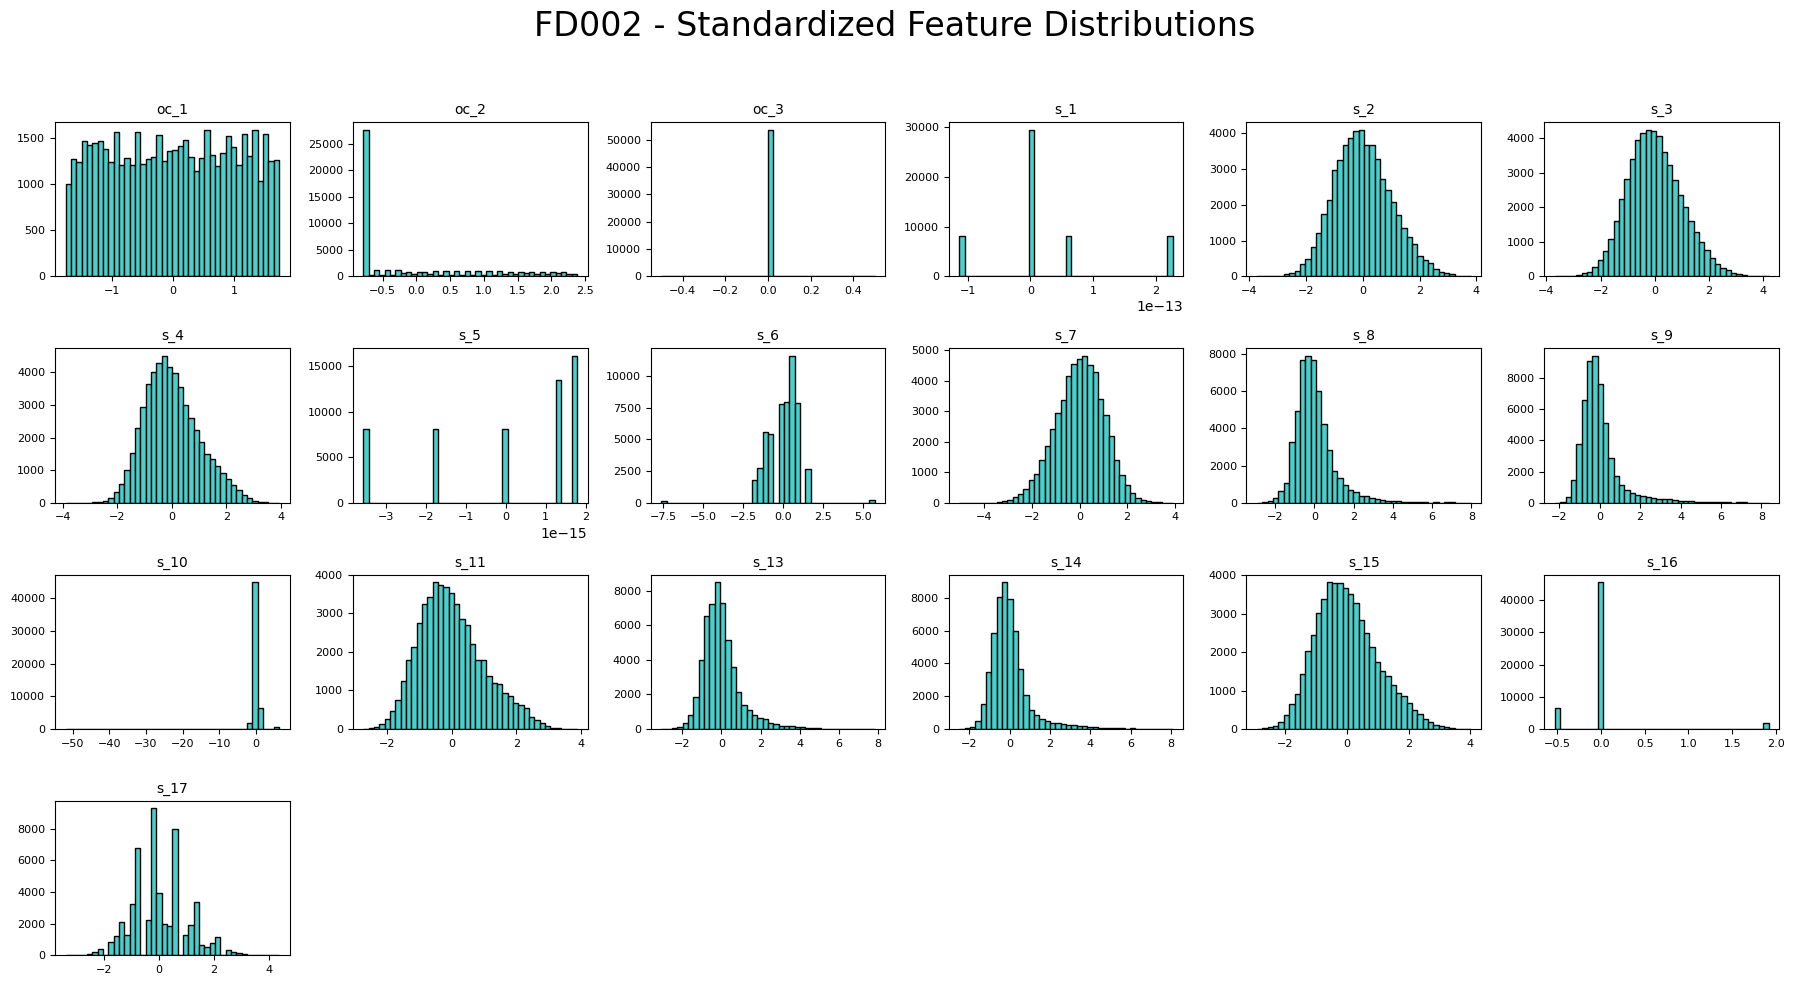

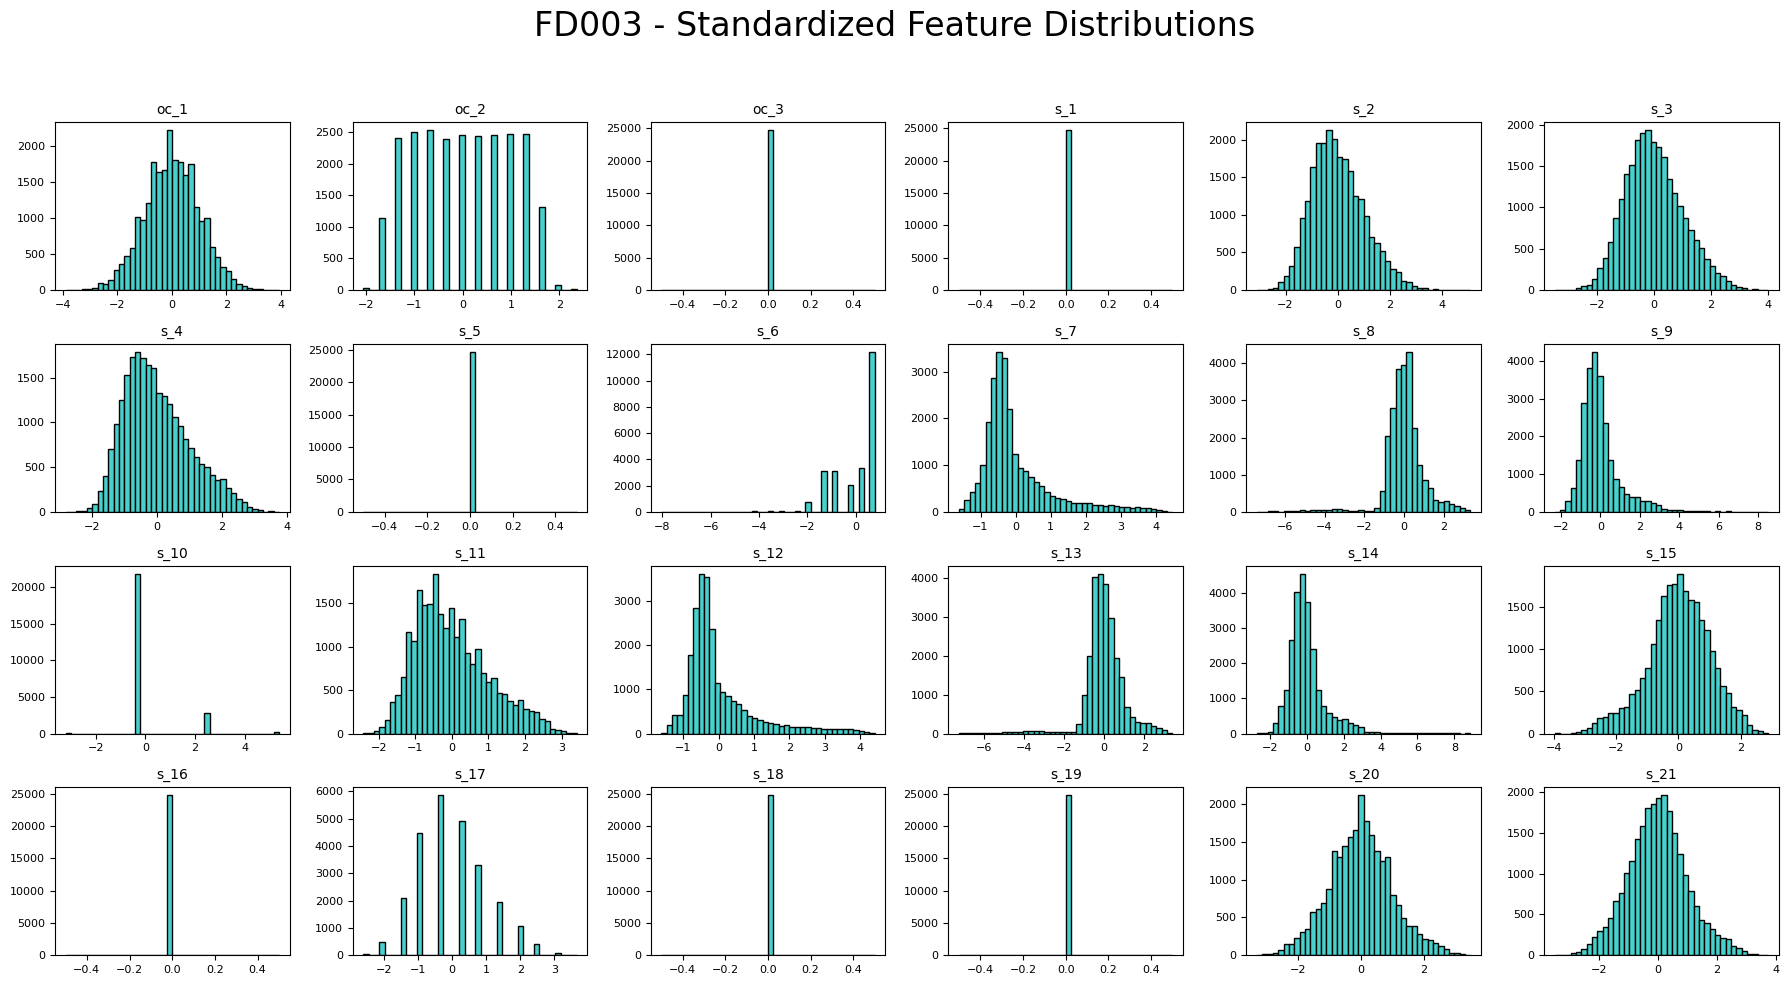

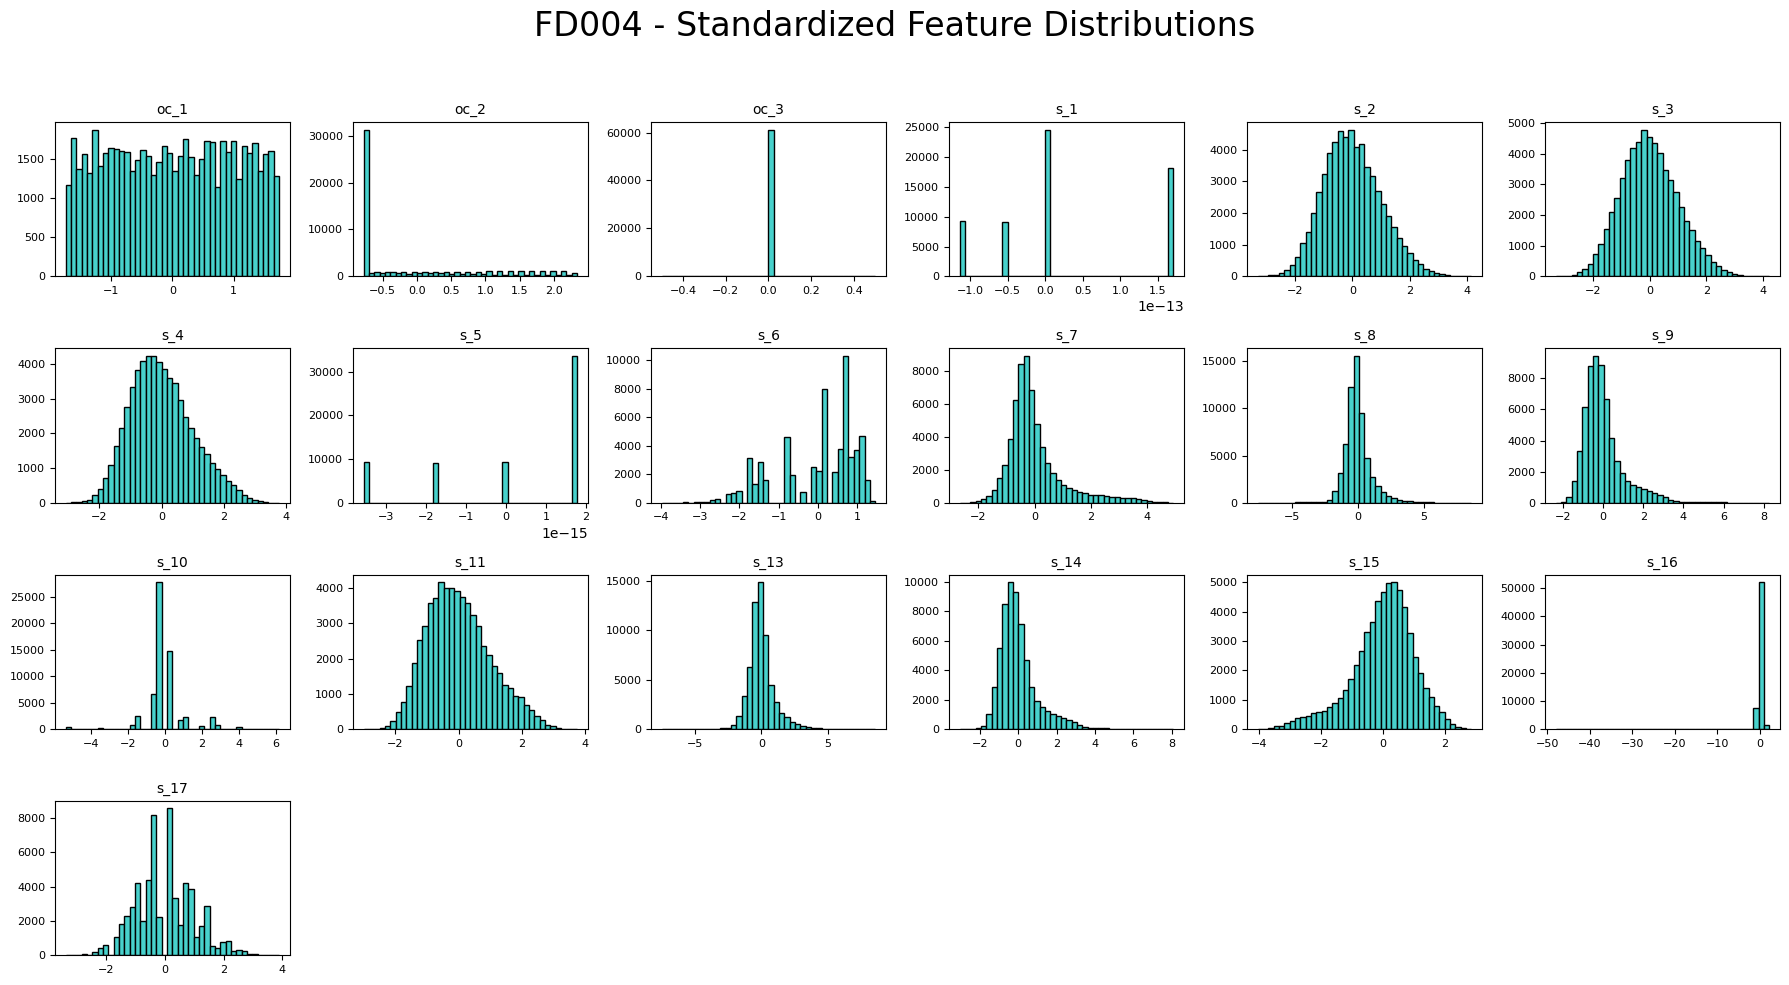

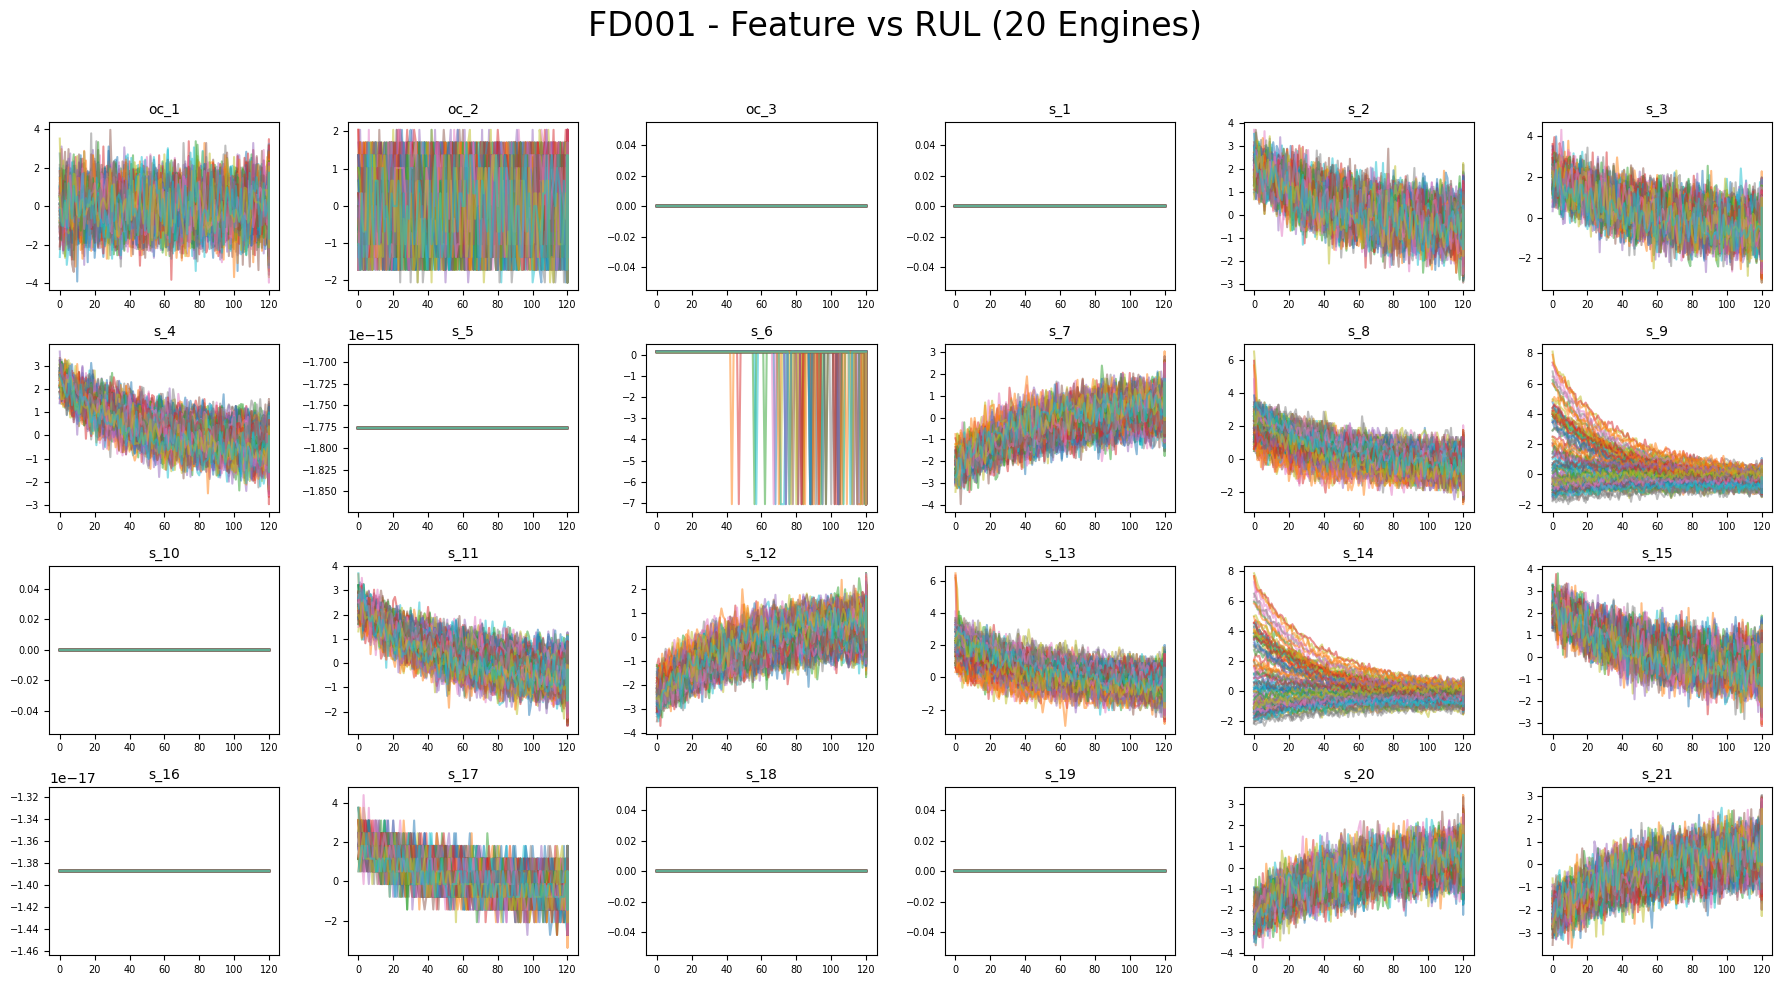

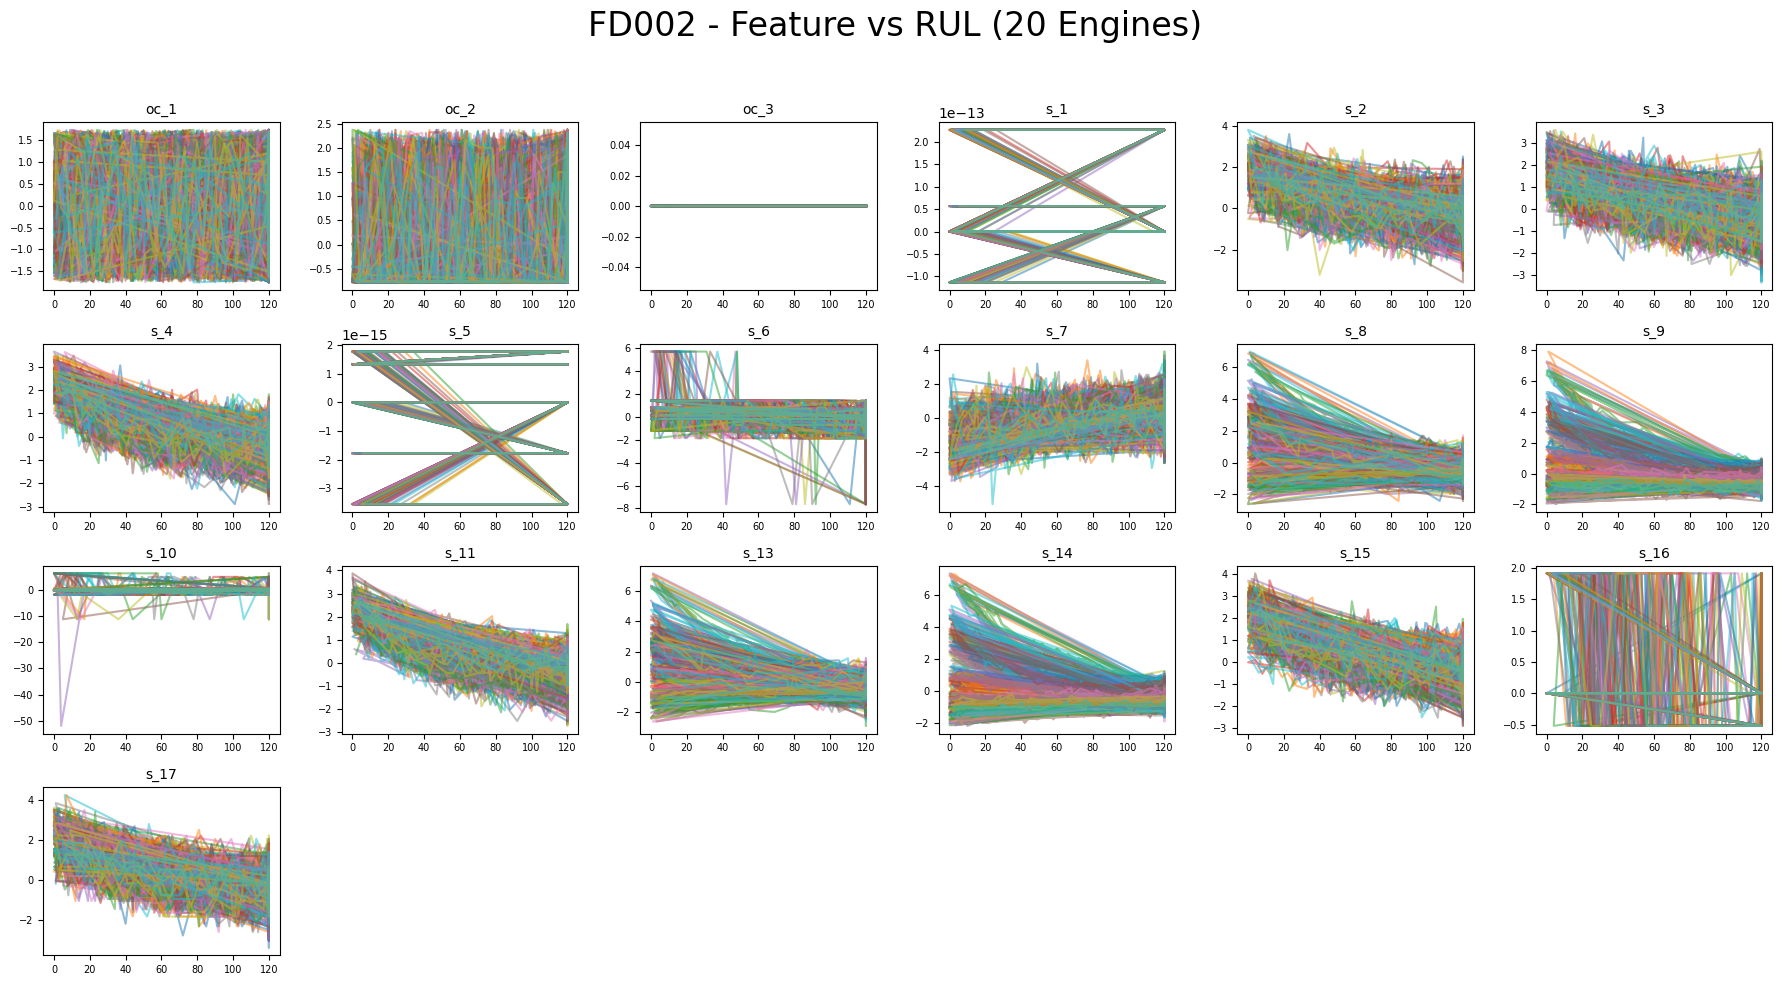

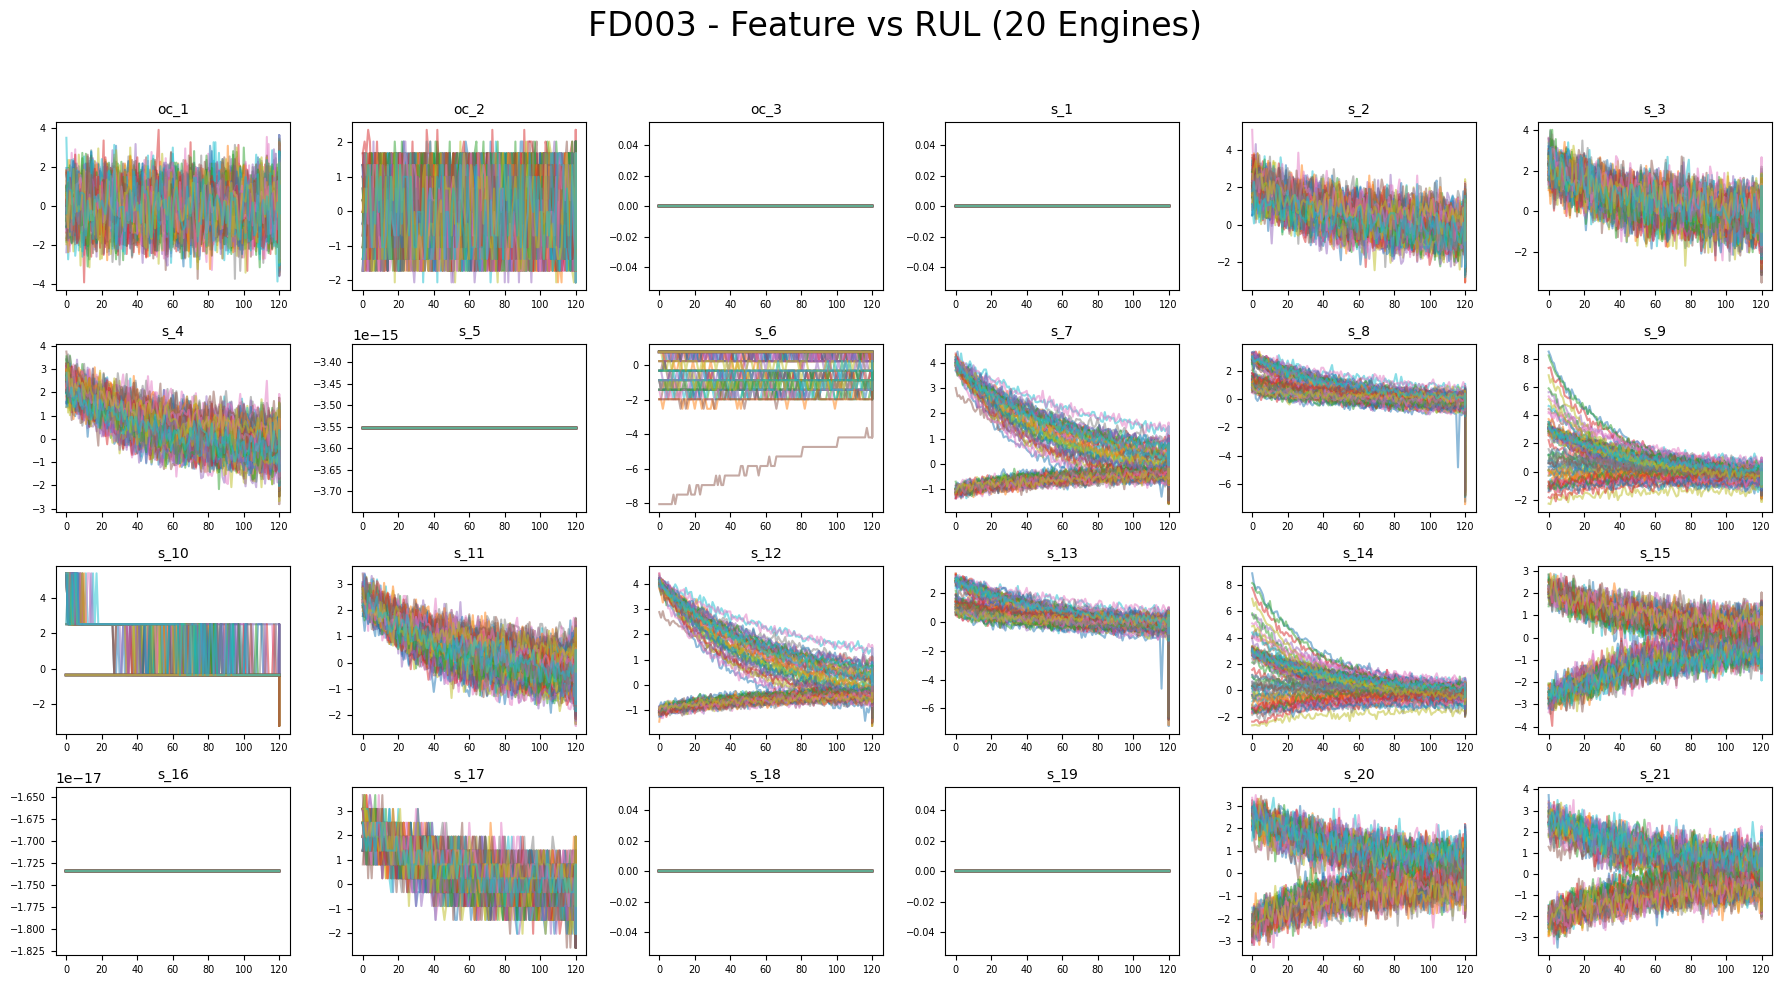

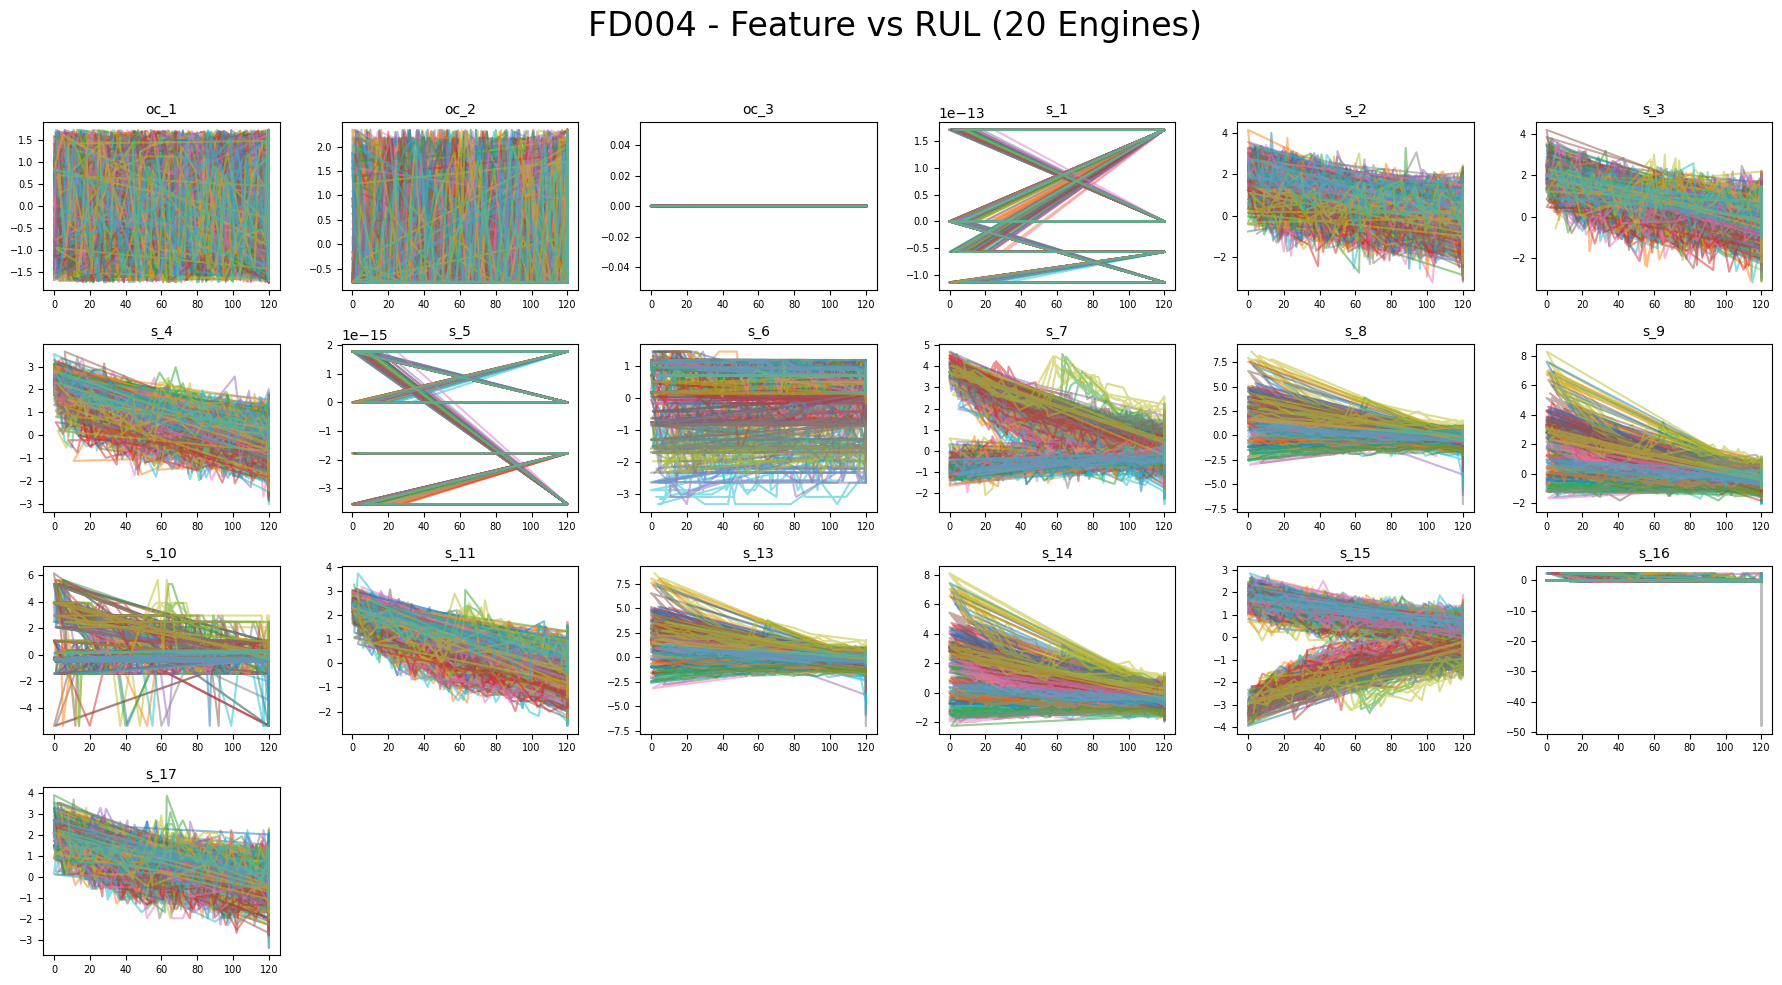

In [9]:
#----------------------------
# 7) Plotting distributions and sample engines
#----------------------------

# This plotting function produces two plots per dataset; one panel of distributions,
# and one panel of twenty randomly chosen engines over time.

def plot_all_feature_diagnostics(normalized_data, ids):

    # 1. Plot Distributions
    for id_ in ids:
        train = normalized_data[f'{id_}_train_rul_norm']
        features = train.drop(columns=['engine', 'time', 'RUL', 'RUL_pw', 'cluster'], errors='ignore')

        n_features = features.shape[1]
        n_cols = 6
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2.5 * n_rows))
        fig.suptitle(f'{id_} - Standardized Feature Distributions', fontsize=24)

        axes = axes.flatten()
        for i, col in enumerate(features.columns):
            ax = axes[i]
            ax.hist(features[col], bins=40, color='mediumturquoise', edgecolor='black')
            ax.set_title(col, fontsize=10)
            ax.tick_params(labelsize=8)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    # 2. Feature vs RUL by engine
    for id_ in ids:
        train_rul = normalized_data[f'{id_}_train_rul_norm']
        features = train_rul.drop(columns=['engine', 'time', 'RUL', 'RUL_pw', 'cluster'], errors='ignore')
        feature_names = features.columns.tolist()

        engine_ids = train_rul['engine'].unique()
        sampled_ids = np.random.choice(engine_ids, size=100, replace=False)

        n_features = len(feature_names)
        n_cols = 6
        n_rows = (n_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2.5 * n_rows))
        fig.suptitle(f'{id_} - Feature vs RUL (20 Engines)', fontsize=24)

        axes = axes.flatten()
        for eid in sampled_ids:
            engine_data = train_rul[train_rul['engine'] == eid]
            rul = engine_data['RUL_pw']
            engine_features = features.loc[engine_data.index]
            for i, col in enumerate(feature_names):
                ax = axes[i]
                ax.plot(rul, engine_features[col], alpha=0.5)
                ax.set_title(col, fontsize=10)
                ax.tick_params(labelsize=7)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_all_feature_diagnostics(normalized_data, ids)

## Further feature selection

In [10]:
#----------------------------
# 8) Manual feature selection based on plot analysis
#----------------------------

# Specify which sensors to drop for each dataset based on visual inspection
# We proceed conservatively in order not to discard potentially useful information.
sensors_to_drop = {
    'FD001': ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19'],
    'FD002': [],
    'FD003': ['s_1', 's_5', 's_16', 's_18', 's_19'],
    'FD004': ['s_16']
}

# Drop specified sensors for each dataset
for id_ in ids:
    train_df = normalized_data[f'{id_}_train_rul_norm']
    test_df = normalized_data[f'{id_}_test_rul_norm']

    # Get list of sensors to drop for this dataset
    to_drop = sensors_to_drop[id_]

    # Drop from both train and test
    # Check if columns exist before dropping to avoid stopping due to errors
    existing_cols = [col for col in to_drop if col in train_df.columns]

    if existing_cols:
        normalized_data[f'{id_}_train_rul_norm'] = train_df.drop(columns=existing_cols)
        normalized_data[f'{id_}_test_rul_norm'] = test_df.drop(columns=existing_cols)

        print(f"{id_}: Manually dropped {len(existing_cols)} sensors: {existing_cols}")

        # Print remaining feature count to check the shape of the datasets
        cols_to_exclude = ['engine', 'time', 'RUL', 'RUL_pw', 'cluster']
        remaining_features = normalized_data[f'{id_}_train_rul_norm'].columns.difference(cols_to_exclude, sort=False)

        print(f"Remaining sensor features: {len(remaining_features)}")
    else:
        print(f"{id_}: No sensors were dropped (specified sensors not found in dataset)")

    print("---")

# Save the normalized data for later use
# This is needed for the per-engine RUL plot that displays predicted RUL vs
# true RUL in the evaluation of the ensemble model.

with open(f'{file_path}tensors/normalized_data.pkl', 'wb') as f:
    pickle.dump(normalized_data, f)

FD001: Manually dropped 6 sensors: ['s_1', 's_5', 's_10', 's_16', 's_18', 's_19']
Remaining sensor features: 18
---
FD002: No sensors were dropped (specified sensors not found in dataset)
---
FD003: Manually dropped 5 sensors: ['s_1', 's_5', 's_16', 's_18', 's_19']
Remaining sensor features: 19
---
FD004: Manually dropped 1 sensors: ['s_16']
Remaining sensor features: 18
---


## Data Augmentation

This section defines, visualizes and performs the data augmentation procedure that is the final step in our pre-processing schedule.

We first define three data augmentation functions based on the literature. In a second step, we create a simple illustration of how these methods work to convey their functioning to the reader of the report.

Finally, we apply the data augmentation to the datasets. The sliding window procedure is performed separately with length 50 for the transformer model as its architecture requires longer extracts.

In [11]:
#----------------------------
# 9) Data Augmentation Functions
#----------------------------

def sliding_window(data, window_size, stride=1):
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        window = data.iloc[i:i+window_size].copy()
        windows.append(window)
    return windows

def add_noise(data, noise_level=0.05):
    noisy_data = data.copy()
    sensor_cols = [col for col in data.columns if col.startswith('s_')]

    for col in sensor_cols:
        # Get scale for this column
        scale = noise_level * data[col].std()
        if scale > 0:
            noise = np.random.normal(0, scale, len(data))
            noisy_data[col] = data[col] + noise

    return noisy_data

def permute_series(data, dropout_rate=0.1):
    dropout_data = data.copy()
    sensor_cols = [col for col in data.columns if col.startswith('s_')]

    # Generate dropout mask for each column
    for col in sensor_cols:
        # Generate dropout mask
        mask = np.random.random(len(data)) < dropout_rate
        if not any(mask) and len(data) > 0:
            mask[0] = True

        # Apply dropout, set to NaN
        dropout_data.loc[mask, col] = np.nan

        # Use ffill() and bfill() to fill the missing values with those earlier
        # in the time series (basically interpolation based on preceding values)
        dropout_data[col] = dropout_data[col].ffill().bfill()

    return dropout_data

def time_warping(data, warping_factor=0.2):
    warped_data = data.copy()
    sensor_cols = [col for col in data.columns if col.startswith('s_')]

    # Create warping path
    cycles = range(len(data))
    warping_path = np.linspace(0, np.pi, len(cycles))
    warping = np.sin(warping_path) * warping_factor + 1

    # Create warped time points
    original_time = np.arange(len(data))
    warped_time = np.cumsum(warping)
    warped_time = warped_time * (len(data) - 1) / warped_time[-1]

    # Apply warping to each sensor
    for col in sensor_cols:
        original_signal = data[col].values
        # Use interpolation to get values at warped time points
        warped_signal = np.interp(original_time, warped_time, original_signal)
        warped_data[col] = warped_signal

    return warped_data

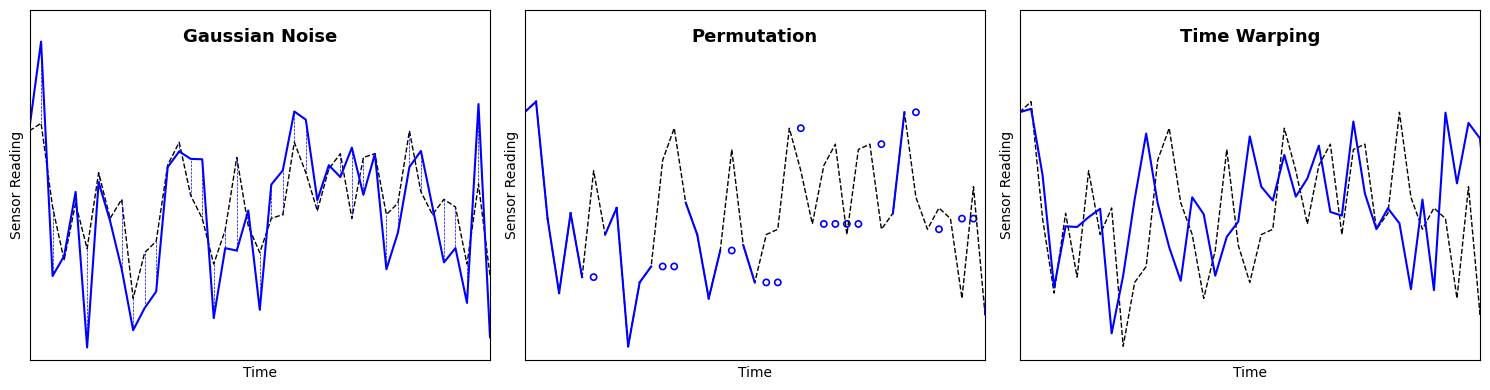

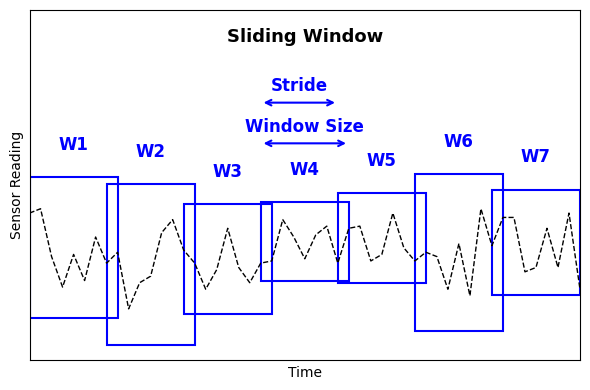

In [12]:
# ----------------------------
# 10) Data Augmentation Illustration
# ----------------------------

# Choose sample engine and sensor
engine_idx = 0
sensor = 's_11'

# Window parameters (the actual parameters are different, this is just for
# illustration of the concept; for the real data we use size 30 and size 50).
window_size = 8
stride = 7
starts = list(range(0, 50 - window_size + 1, stride))

df = normalized_data['FD001_train_rul_norm']
sample_engine = df[df['engine'] == df['engine'].unique()[engine_idx]].reset_index(drop=True)
x_vals = np.arange(len(sample_engine))
y_vals = sample_engine[sensor].values

#---------------------------------------------------------------

# Apply the three augmentations
# A) Gaussian noise
noisy_engine = add_noise(sample_engine, noise_level=0.5)

# B) Time series permutation
dropout_data = sample_engine.copy()
mask = np.random.rand(len(dropout_data)) < 0.4
dropout_data.loc[mask, sensor] = np.nan
dropout_data[sensor] = dropout_data[sensor].ffill().bfill()
kept_mask = ~mask
interpolated_mask = mask

# C) Time warping
warped_engine = time_warping(sample_engine, warping_factor=0.5)

#---------------------------------------------------------------

# First figure: shows the three different augmentation methods in one row

fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# A) Gaussian Noise
axs[0].plot(x_vals, y_vals, linestyle='--', color='black', linewidth=1)
axs[0].plot(x_vals, noisy_engine[sensor], color='blue', linewidth=1.5)
for x, y_orig, y_noisy in zip(x_vals, y_vals, noisy_engine[sensor]):
    axs[0].plot([x, x], [y_orig, y_noisy], linestyle='dashed', color='blue', linewidth=0.5)
y_min = min(np.min(y_vals), np.min(noisy_engine[sensor]))
y_max = max(np.max(y_vals), np.max(noisy_engine[sensor]))
axs[0].set_ylim(y_min - 0.1, y_max - 2.5)
axs[0].text(0.5, 0.95, "Gaussian Noise", transform=axs[0].transAxes,
            fontsize=13, fontweight='bold', ha='center', va='top')

# B) Permutation
axs[1].plot(x_vals, y_vals, linestyle='--', color='black', linewidth=1)
for i in range(1, len(x_vals)):
    if kept_mask[i] and kept_mask[i - 1]:
        axs[1].plot(x_vals[i - 1:i + 1], dropout_data[sensor].iloc[i - 1:i + 1], color='blue', linewidth=1.5)
axs[1].scatter(x_vals[interpolated_mask], dropout_data[sensor].iloc[interpolated_mask],
               edgecolor='blue', facecolor='none', s=20, linewidth=1.2)
y_min = min(np.min(y_vals), np.min(dropout_data[sensor]))
y_max = max(np.max(y_vals), np.max(dropout_data[sensor]))
axs[1].set_ylim(y_min - 0.1, y_max - 2.5)
axs[1].text(0.5, 0.95, "Permutation", transform=axs[1].transAxes,
            fontsize=13, fontweight='bold', ha='center', va='top')

# C) Time Warping
axs[2].plot(x_vals, y_vals, linestyle='--', color='black', linewidth=1)
axs[2].plot(x_vals, warped_engine[sensor], color='blue', linewidth=1.5)
y_min = min(np.min(y_vals), np.min(warped_engine[sensor]))
y_max = max(np.max(y_vals), np.max(warped_engine[sensor]))
axs[2].set_ylim(y_min - 0.1, y_max - 2.5)
axs[2].text(0.5, 0.95, "Time Warping", transform=axs[2].transAxes,
            fontsize=13, fontweight='bold', ha='center', va='top')

# Shared formatting for the three plots
for ax in axs:
    ax.set_xlim(0, 40)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel("Time")
    ax.set_ylabel("Sensor Reading")

plt.tight_layout()
plt.savefig("augmentation_top3.png", dpi=300, bbox_inches='tight')
plt.show()

# Second figure: Illustration of the sliding window technique to generate
# shorter sequences that are later fed into the models.

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(x_vals, y_vals, linestyle='--', color='black', linewidth=1)
for i, start in enumerate(starts):
    end = start + window_size
    window_y = y_vals[start:end]
    y_min = window_y.min()
    y_max = window_y.max()
    y_range = y_max - y_min
    pad = 0.4 * y_range if y_range > 0 else 0.4
    rect = patches.Rectangle((start, y_min - pad), window_size, y_range + 2 * pad,
                              linewidth=1.5, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text(start + window_size / 2, y_max + pad + 0.4, f'W{i+1}',
            fontsize=12, color='blue', ha='center', va='bottom', fontweight='bold')

# Annotations for window size and stride
if len(starts) > 4:
    start_w4 = starts[3]
    start_w5 = starts[4]
    top_y = y_vals[start_w4:start_w5 + window_size].max() + 1.2  # <<< lower again

    # Window Size Arrow
    ax.annotate('', xy=(start_w4, top_y), xytext=(start_w4 + window_size, top_y),
                arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5))
    ax.text(start_w4 + window_size / 2, top_y + 0.2, 'Window Size',
            ha='center', color='blue', fontsize=12, fontweight='bold')

    # Stride Arrow
    ax.annotate('', xy=(start_w4, top_y + 0.7), xytext=(start_w5, top_y + 0.7),
                arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5))
    ax.text((start_w4 + start_w5) / 2, top_y + 0.9, 'Stride',
            ha='center', color='blue', fontsize=12, fontweight='bold')

ax.text(0.5, 0.95, "Sliding Window", transform=ax.transAxes,
        fontsize=13, fontweight='bold', ha='center', va='top')

# Formatting
ax.set_xlim(0, 50)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_xlabel("Time")
ax.set_ylabel("Sensor Reading")

plt.tight_layout()
plt.savefig("augmentation_sliding_window.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
#----------------------------
# 11) Implement Data Augmentation
#----------------------------

# Parameters
stride = 5

# Different levels of data augmentation
# These are saved separately so they can later be used to determine whether
# data augmentation improves model predictions.

# We produce data for 2 augmentation levels, 2 window sizes and 4 datasets, so
# 16 sets of X and y datasets in total.

augmentation_levels = [
    {
        'aug_level': "none",
        'data_aug': 0,
        'noise_level': 0.0,
        'dropout_rate': 0.0,
        'warping_factor': 0.0
    },
    {
        'aug_level': "medium",
        'data_aug': 1,
        'noise_level': 0.1,
        'dropout_rate': 0.2,
        'warping_factor': 0.3
    },
]

save_dir_base = f'{file_path}tensors'
# Loop through window sizes
for window_size in [30, 50]:
    # Adjust save directory depending on window size (only the transformer model
    # uses the longer window size of 50)
    if window_size == 30:
        save_dir = save_dir_base  # Save directly into /tensors
    else:  # i.e. window_size == 50
        save_dir = os.path.join(save_dir_base, 'transformer')  # Save into /tensors/transformer subfolder

    # Loop through each augmentation level
    for aug_params in augmentation_levels:
        aug_level = aug_params['aug_level']
        data_aug = aug_params['data_aug']
        noise_level = aug_params['noise_level']
        dropout_rate = aug_params['dropout_rate']
        warping_factor = aug_params['warping_factor']

        print(f"\nProcessing Augmentation Level: {aug_level.upper()} - Window Size {window_size}")

        # Dictionary to store data for this augmentation level
        augmented_data = {}

        # Now for each dataset id (meaning FD001 to FD004)
        for id_ in ids:
            print(f"\nProcessing dataset {id_}...")

            train_df = normalized_data[f'{id_}_train_rul_norm']
            all_windows = []

            for eid in train_df['engine'].unique():
                engine_df = train_df[train_df['engine'] == eid].reset_index(drop=True)
                engine_windows = sliding_window(engine_df, window_size, stride)

                for window in engine_windows:
                    all_windows.append(window)

                    if data_aug == 1:
                        noisy_window = add_noise(window, noise_level=noise_level)
                        dropout_window = permute_series(window, dropout_rate=dropout_rate)
                        warped_window = time_warping(window, warping_factor=warping_factor)
                        all_windows.extend([noisy_window, dropout_window, warped_window])

            print(f"  Total windows after augmentation: {len(all_windows)}")

            # Extract X and y
            sensor_cols = [col for col in all_windows[0].columns if col.startswith('s_')]
            X_data = np.array([window[sensor_cols].values for window in all_windows])
            y_data = np.array([window['RUL_pw'].values[-1] for window in all_windows])

            # Set name of the file depending on augmentation level
            # We name those with data augmentation _augmented and those without
            # data augmentation without any suffix in order to tell them apart.

            if aug_level == "none":
                x_name = f"{id_}_X.npy"
                y_name = f"{id_}_y.npy"
            else: # i.e. if the augmentation level is medium instead
                x_name = f"{id_}_X_augmented.npy"
                y_name = f"{id_}_y_augmented.npy"

            # Save
            np.save(os.path.join(save_dir, x_name), X_data)
            np.save(os.path.join(save_dir, y_name), y_data)

            print(f"  Saved dataset {id_}: X shape {X_data.shape}, y shape {y_data.shape}")

        print(f"\nSaved all datasets for augmentation level: {aug_level.upper()} - Window Size {window_size}")


Processing Augmentation Level: NONE - Window Size 30

Processing dataset FD001...
  Total windows after augmentation: 3586
  Saved dataset FD001: X shape (3586, 30, 15), y shape (3586,)

Processing dataset FD002...
  Total windows after augmentation: 9338
  Saved dataset FD002: X shape (9338, 30, 16), y shape (9338,)

Processing dataset FD003...
  Total windows after augmentation: 4406
  Saved dataset FD003: X shape (4406, 30, 16), y shape (4406,)

Processing dataset FD004...
  Total windows after augmentation: 10901
  Saved dataset FD004: X shape (10901, 30, 15), y shape (10901,)

Saved all datasets for augmentation level: NONE - Window Size 30

Processing Augmentation Level: MEDIUM - Window Size 30

Processing dataset FD001...
  Total windows after augmentation: 14344
  Saved dataset FD001: X shape (14344, 30, 15), y shape (14344,)

Processing dataset FD002...
  Total windows after augmentation: 37352
  Saved dataset FD002: X shape (37352, 30, 16), y shape (37352,)

Processing datas

## Creating the final test datasets

This final block now creates the test datasets for use in the model pipelines. We use the sliding window technique on the test datasets as well since the models expect this shape; for the final RUL calculation, again in line with the literature, we only keep the final window and will aim to predict the RUL at the last point of that window later.

In [14]:
#----------------------------
# 12) Creating the final test datasets
#----------------------------

# We finally create the test datasets based on the two window sizes as well.
# Note that we apply no data augmentation to the test datasets, they are only formatted
# into the windows so that the model can take them with the usual input shape.

# For the model evaluation later, we construct the test datasets such that only the
# final window (i.e. beginning at T_max - window_size and ending at T_max) is saved,
# as well as the corresponding RUL in the last period. This is the usual approach in
# the literature, although alternative approaches such as taking the last 5 windows
# and their RULs and averaging the prediction would also be possible.

# If an engine sequence is shorter than window_size, we pad the beginning with zeroes
# until it reaches window_size.

base_path = f'{file_path}tensors/'

for window_size in [30, 50]:
    if window_size == 30:
        file_path = base_path
    else:  # window_size == 50
        file_path = os.path.join(base_path, 'transformer')

    for dataset_id in ids:
        test_df = normalized_data[f'{dataset_id}_test_rul_norm']
        sensor_columns = [c for c in test_df.columns if c.startswith('s_')]

        Xs, Ys = [], []
        for eid in test_df['engine'].unique():
            sub = test_df[test_df['engine'] == eid]
            arr = sub[sensor_columns].values.astype(np.float32)
            final = sub['RUL_pw'].values[-1].astype(np.float32)

            if arr.shape[0] >= window_size:
                w = arr[-window_size:]
            else:
                w = np.zeros((window_size, arr.shape[1]), dtype=np.float32)
                w[-arr.shape[0]:] = arr

            Xs.append(w)
            Ys.append(final)

        X_test = np.stack(Xs, axis=0)
        y_test = np.array(Ys, dtype=np.float32)

        # Save to Drive as compressed .npz
        # We again save these separately for the transformer model and for the
        # other models since they require different window sizes.

        out_path = os.path.join(file_path, f'{dataset_id}_test_windows.npz')
        os.makedirs(file_path, exist_ok=True)
        np.savez_compressed(out_path, X_test=X_test, y_test=y_test)
        print(f"Saved {dataset_id}: X_test {X_test.shape}, y_test {y_test.shape} → {out_path}")

Saved FD001: X_test (100, 30, 15), y_test (100,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/FD001_test_windows.npz
Saved FD002: X_test (259, 30, 16), y_test (259,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/FD002_test_windows.npz
Saved FD003: X_test (100, 30, 16), y_test (100,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/FD003_test_windows.npz
Saved FD004: X_test (248, 30, 15), y_test (248,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/FD004_test_windows.npz
Saved FD001: X_test (100, 50, 15), y_test (100,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/transformer/FD001_test_windows.npz
Saved FD002: X_test (259, 50, 16), y_test (259,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/transformer/FD002_test_windows.npz
Saved FD003: X_test (100, 50, 16), y_test (100,) → /content/drive/MyDrive/Colab Notebooks/I Learn Deep/tensors/transformer/FD003_test_windows.npz
Saved FD004: X_test (248, 